## Цель: разработать автоматизированный пайплайн для сбора и анализа статистики по существующим структурам белка.
**Задачи:**
1. Используя API UniProt, загрузить последовательность целевого белка (на примере CRISPR-associated endonuclease Cas9/Csn1, UniProt ID: Q99ZW2).
2. Сохранить последовательность основной изоформы в формате FASTA.
3. Вывести последовательности изоформ белка, если они присутствуют.
4. С помощью REST API RSCB PDB найти структуры, содержащие последовательности с идентичностью ≥90% к целевой последовательности.
5. Для найденных структур извлечь информацию о методе определения структуры, разрешении и дате депонирования.
6. Отсортировать структуры по разрешению и представить основную информацию о структурах с наивысшим разрешением.
7. Собрать данные в таблицу и визуализировать результаты с помощью графиков.

In [61]:
import requests
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re
from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [62]:
BASE = 'https://rest.uniprot.org'
KB_ENDPOINT = '/uniprotkb/search'
TOOL_ENDPOINT = '/uploadlists/'

In [63]:
# функция для загрузки последовательности из Uniprot
def fetch_sequence(uniprot_id):
    """
    Введите uniprot_id исследуемого белка
    """
    url = f'https://www.uniprot.org/uniprot/{uniprot_id}.fasta'
    response = requests.get(url)
    if response.ok:
        fasta_data = response.text
        sequence = ''.join(fasta_data.split('\n')[1:])
        return sequence

In [64]:
my_sequence = fetch_sequence('Q99ZW2')

In [65]:
# сохраняем последовательность белка в fasta file
payload1 = {'query': 'Q99ZW2', 'format': 'fasta', 'includeIsoform':'false'}
result1 = requests.get(BASE + KB_ENDPOINT, params=payload1)
if result1.ok:
    print('Файл сохранен')
else:
    print('Something went wrong ', result1.status_code)

filename_init = 'Cas9.fasta'
with open(filename_init, "w") as f:
    f.write(result1.text)
record_init = SeqIO.read(filename_init, 'fasta')
print(record_init)

Файл сохранен
ID: sp|Q99ZW2|CAS9_STRP1
Name: sp|Q99ZW2|CAS9_STRP1
Description: sp|Q99ZW2|CAS9_STRP1 CRISPR-associated endonuclease Cas9/Csn1 OS=Streptococcus pyogenes serotype M1 OX=301447 GN=cas9 PE=1 SV=1
Number of features: 0
Seq('MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFD...GGD')


In [66]:
# выводим информацию об изоформах
payload = {'query': 'Q99ZW2', 'format': 'fasta', 'includeIsoform':'true'}
result = requests.get(BASE + KB_ENDPOINT, params=payload)
fasta_list = re.split(r'\n(?=>)', result.text)
isoforms = len(fasta_list)
#print(result.text)
if isoforms > 1:
    print(f"Isoforms count = {isoforms} \n {result.text}")
else: 
    print(f"Isoforms count = {isoforms}")

Isoforms count = 1


In [67]:
# получим список структур, которые содержат последовательности, идентичные на 90% исследуемой последовательности
url = 'https://search.rcsb.org/rcsbsearch/v2/query'
query = {
    "query": {
            "type": "terminal",
            "service": "sequence",
            "parameters": {
                "evalue_cutoff": 1,
                "identity_cutoff": 0.9,
                "sequence_type": "protein",
                "value": f'{my_sequence}'
            }
        },
        "request_options": {
            "scoring_strategy": "sequence",
            "paginate": {
            "start": 0,
            "rows": 100
            }
        },
        "return_type": "entry" 
    }
response = requests.post(url, json=query)
results = response.json()

# получаем список идентификаторов (PDB ID)
pdb_ids = [entry['identifier'] for entry in results['result_set']]

# выводим полученные идентификаторы
print(pdb_ids)

['4CMP', '4CMQ', '5F9R', '5XBL', '6IFO', '6O0X', '6O0Y', '6O0Z', '7S37', '7S4U', '7S4V', '7S4X', '7Z4J', '7Z4L', '8FZT', '8G1I', '8YE6', '8YE9', '8YNY', '9B2K', '9C9P', '9CGU', '9EAK', '9EAL', '9ED9', '9EDA', '9EDB', '9JL1', '9JL2', '9JL4', '4ZT0', '5VZL', '6MCB', '6MCC', '7S36', '7S38', '7S3H', '4UN3', '4UN4', '4UN5', '5FQ5', '5VW1', '5Y36', '6K3Z', '6K57', '7OX7', '7OX8', '7OX9', '7OXA', '7QQO', '7QQP', '7QQQ', '7QQR', '7QQS', '7QQT', '7QQU', '7QQV', '7QQW', '7QQX', '7QQZ', '7QR0', '7QR1', '7QR5', '7QR7', '7QR8', '7Z4C', '7Z4D', '7Z4E', '7Z4G', '7Z4H', '7Z4I', '7Z4K', '7ZO1', '8KAG', '8KAH', '8KAI', '8KAJ', '8KAK', '8KAL', '8KAM', '4ZT9', '8WUS', '8WUT', '8WUU', '8WUV', '8YGJ', '5FW2', '7V59', '5FW1', '4OO8', '7VK9', '5FW3', '8TZZ', '6AEB', '6AEG', '6K4U', '5B2S', '6VPC', '9K4C', '9K4D']


In [68]:
# запрос информации о методе получения, разрешении и дате получения для каждой структуры
def fetch_structure_info(pdb_id):
    url = f'https://data.rcsb.org/rest/v1/core/entry/{pdb_id}'
    response = requests.get(url)
    if response.ok:
        data = response.json()
        method = data['rcsb_entry_info']['experimental_method']
        resolution_list = data['rcsb_entry_info']['resolution_combined']
        resolution = float(resolution_list[0]) 
        deposition_date = data['rcsb_accession_info']['initial_release_date']
        return method, resolution, deposition_date

# запрос информации для каждой структуры
data = []
for pdb_id in pdb_ids:
    method, resolution, deposition_date = fetch_structure_info(pdb_id)
    if method:
        data.append({'PDB_ID': pdb_id, 'Method': method, 'Resolution': resolution, 'Deposition_Date': deposition_date})

# создаем DataFrame из собранных данных
df = pd.DataFrame(data)
df_1 = df.copy()
    
# преобразуем столбец 'Deposition Date' в тип datetime
df_1['Deposition_Date'] = pd.to_datetime(df_1['Deposition_Date']).dt.date
df['Deposition_Date'] = pd.to_datetime(df['Deposition_Date'], errors='coerce')

In [69]:
# сортируем по разрешению (по возрастанию - в данном случае, чем меньше разрешение, тем лучше) и берем первые 5 структур
best_resolution_structures = df_1.sort_values('Resolution', ascending=True).head(5)
best_resolution_structures

,PDB_ID,Method,Resolution,Deposition_Date
40,5FQ5,X-ray,2.136,2016-03-23
48,7OXA,X-ray,2.150,2021-09-15
96,5B2S,X-ray,2.200,2016-03-23
59,7QQZ,X-ray,2.250,2022-10-26
56,7QQV,X-ray,2.250,2022-10-26


In [70]:
def fetch_best_protein_info(pdb_id):
    """
    Получает информацию о названии белка и статье по PDB ID
    """
    url = f'https://data.rcsb.org/rest/v1/core/entry/{pdb_id}'
    response = requests.get(url)
    
    if response.ok:
        data = response.json()
        method = data['rcsb_entry_info']['experimental_method']
        resolution_list = data['rcsb_entry_info']['resolution_combined']
        resolution = float(resolution_list[0]) 
        r_factor = data.get('refine', [])
        first_refine = r_factor[0]
        r_free = first_refine.get('ls_rfactor_rfree', 'N/A')
        r_work = first_refine.get('ls_rfactor_rwork', 'N/A')
        # Название структуры
        protein_name = data.get('struct', {}).get('title', 'N/A')
        # Информация о статье
        citation = data.get('rcsb_primary_citation', {})
        article_info = {
            'title': citation.get('title', 'N/A'),
            'journal': citation.get('journal_abbrev', 'N/A'),
            'year': citation.get('year', 'N/A'),
            'doi': citation.get('pdbx_database_id_doi', 'N/A'),
            'pubMed_id': citation.get('pdbx_database_id_pub_med', 'N/A')
        }
        return method, resolution, protein_name, article_info, r_free, r_work
    else:
        return 'N/A', {}

In [71]:
# получим более подробную информацию о 5 структурах с самым лучшим разрешением
best_structures = []
for pdb_id in best_resolution_structures.PDB_ID:
    method, resolution, protein_name, article_info, r_free, r_work = fetch_best_protein_info(pdb_id)
    if protein_name:
        best_structures.append({'PDB_ID': pdb_id, 'Method': method, 'Resolution': resolution, 
                                'R_free': r_free, 'R_work': r_work,
                                'Structure_name': protein_name, 'Article_info': article_info})

# создаем DataFrame из собранных данных
best_structures = pd.DataFrame(best_structures)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
best_structures

,PDB_ID,Method,Resolution,R_free,R_work,Structure_name,Article_info
0,5FQ5,X-ray,2.136,0.2248,0.1909,Crystal structure of Cas9-sgRNA-DNA complex solved by native SAD phasing,"{'title': 'Data-Collection Strategy for Challenging Native Sad Phasing.', 'journal': 'Acta Crystallogr.,Sect.D', 'year': 2016, 'doi': '10.1107/S2059798315024110', 'pubMed_id': 26960129}"
1,7OXA,X-ray,2.150,0.2259,0.1977,Target-bound SpCas9 complex with AAVS1 chimeric RNA-DNA guide,"{'title': 'Conformational control of Cas9 by CRISPR hybrid RNA-DNA guides mitigates off-target activity in T cells.', 'journal': 'Mol.Cell', 'year': 2021, 'doi': '10.1016/j.molcel.2021.07.035', 'pubMed_id': 34478654}"
2,5B2S,X-ray,2.200,0.2309,0.2071,Crystal structure of the Streptococcus pyogenes Cas9 EQR variant in complex with sgRNA and target DNA (TGAG PAM),"{'title': 'Structural Basis for the Altered PAM Specificities of Engineered CRISPR-Cas9', 'journal': 'Mol.Cell', 'year': 2016, 'doi': '10.1016/j.molcel.2016.02.018', 'pubMed_id': 26990991}"
3,7QQZ,X-ray,2.250,0.2472,0.2170,SpCas9 bound to FANCF off-target7 DNA substrate,"{'title': 'Structural basis for Cas9 off-target activity.', 'journal': 'Cell', 'year': 2022, 'doi': '10.1016/j.cell.2022.09.026', 'pubMed_id': 36306733}"
4,7QQV,X-ray,2.250,0.2304,0.1947,SpCas9 bound to FANCF off-target3 DNA substrate,"{'title': 'Structural basis for Cas9 off-target activity.', 'journal': 'Cell', 'year': 2022, 'doi': '10.1016/j.cell.2022.09.026', 'pubMed_id': 36306733}"


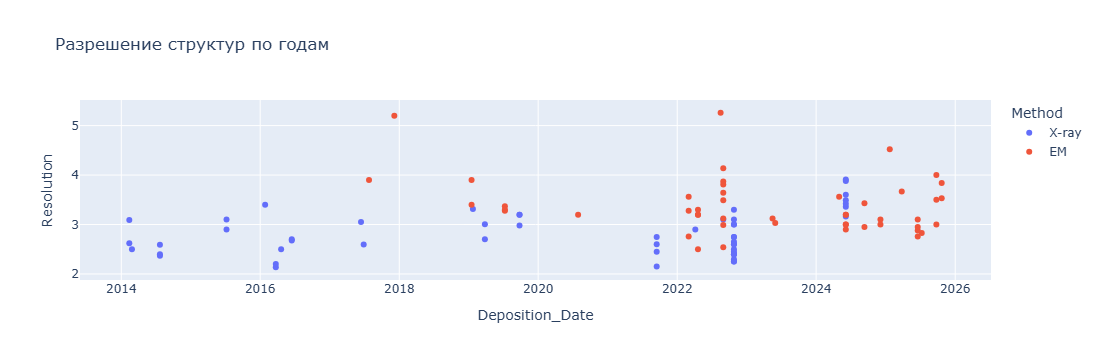

In [72]:
# интерактивный scatter plot
fig = px.scatter(df, x='Deposition_Date', y='Resolution', 
                 color='Method', hover_data=['PDB_ID'],
                 title='Разрешение структур по годам')
fig.show()